In [1]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession

from pyspark.ml import feature, regression, evaluation, Pipeline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.sql import functions as fn, Row
from pyspark import sql
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Loading the dataset
loans_accepted_2007_2018 = spark.read.csv("/FileStore/tables/accepted_2007_to_2018Q4.csv", header='true')

In [3]:
#Data Cleaning

In [4]:
#Forming a subset from 151 features to 37 features
columns_list=loans_accepted_2007_2018.columns
l=columns_list[0:36]
l

Out[ 3 ]: ['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util']

In [5]:
#Forming a dataset of the above selected 37 features
loans_accepted_clean1=loans_accepted_2007_2018.select([c for c in loans_accepted_2007_2018.columns if c in l])

In [6]:
#Converting the dataset to pandas
loans_pandas=loans_accepted_clean1.toPandas()

In [7]:
#Again check missing values count and percent in remaining columns
Value_counts=loans_pandas.isnull().sum().sort_values(ascending=False)
percent= (loans_pandas.isnull().sum()/loans_pandas.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([Value_counts, percent],axis=1, keys=["Value_counts", "Percent"])
missing_data

,Value_counts,Percent
member_id,2260701,100.000000
desc,2134633,94.423500
mths_since_last_record,1901354,84.104621
mths_since_last_delinq,1158374,51.239593
emp_title,167002,7.387178
emp_length,146940,6.499754
title,23359,1.033264
revol_util,1867,0.082585
dti,1745,0.077188
open_acc,143,0.006325


In [8]:
#Dropping some more irrelevant features based on missing values
loans_accepted_clean=loans_pandas.drop(['desc','member_id','url','title','zip_code','id','sub_grade','pymnt_plan','mths_since_last_record','mths_since_last_delinq','pub_rec','revol_bal'], axis=1)
loans_accepted_clean.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,revol_util
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,...,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,29.7
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,...,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,19.2


In [9]:
#Renaming the column names 
loan_accepted_clean= loans_accepted_clean.rename(columns = {"loan_amnt": "Loan_Amount", 
                                  "funded_amnt":"Funded_Amount", 
                                  "funded_amnt_inv": "Funded_Amount_Invested","term":"Loan_Term","int_rate":"Interest_Rate","installment":"Installment_Amount","grade":"Grade","emp_title":"Employee_Title","emp_length":"Employment_Length","home_ownership":"Home_Ownership_Status","issue_d":"Issue_Date","loan_status":"Loan_Status","purpose":"Purpose","addr_state":"State","delinq_2yrs":"Deliquency_2yrs","earliest_cr_line":"Earliest_Credit_Line","fico_range_low":"Fico_Low","fico_range_high":"Fico_High","inq_last_6mths":"Inquiry_Last_6mnths","open_acc":"Open_Credit_Lines","annual_inc":"Annual_Income","verification_status":"Verification_Status","dti":"Debt_To_Income_Ratio","revol_util":"Revolving_Utlilization"}) 

In [10]:
#Converting the Loan_Term from string to float 
loan_accepted_clean['Loan_Term']= loan_accepted_clean['Loan_Term'].str.extract('(\d+)', expand = False).astype(float)

In [11]:
#Checking the null values in features
loan_accepted_clean.isnull().sum()

Out[ 10 ]: Loan_Amount 33
Funded_Amount 33
Funded_Amount_Invested 33
Loan_Term 33
Interest_Rate 33
Installment_Amount 33
Grade 33
Employee_Title 167002
Employment_Length 146940
Home_Ownership_Status 33
Annual_Income 37
Verification_Status 33
Issue_Date 33
Loan_Status 33
Purpose 34
State 34
Debt_To_Income_Ratio 1745
Deliquency_2yrs 63
Earliest_Credit_Line 63
Fico_Low 34
Fico_High 34
Inquiry_Last_6mnths 64
Open_Credit_Lines 143
Revolving_Utlilization 1867
dtype: int64

In [12]:
#Dropping nulls from the features
loan_accepted_clean=loan_accepted_clean.dropna(axis=0,how ='any')

In [13]:
#Coverting the Issue_Date from string to datetime
import datetime

loan_accepted_clean["Issue_Date"]= pd.to_datetime(loan_accepted_clean["Issue_Date"])
loan_accepted_clean["Issue_Date"].value_counts(ascending=False).head()

Out[ 12 ]: 2016-03-01 57508
2015-10-01 45670
2015-07-01 43451
2018-05-01 42490
2015-12-01 41501
Name: Issue_Date, dtype: int64

In [14]:
#Filtering the data from 2016-2018
start_date = '2016-01-01'
end_date = '2018-12-31'
mask = (loan_accepted_clean['Issue_Date'] > start_date) & (loan_accepted_clean['Issue_Date'] <= end_date)
loan_accepted_clean = loan_accepted_clean.loc[mask]

In [15]:
#Converting the features from string to numeric
loan_accepted_clean['Funded_Amount']=loan_accepted_clean['Funded_Amount'].astype(float)
loan_accepted_clean['Funded_Amount_Invested']=loan_accepted_clean['Funded_Amount_Invested'].astype(float)
loan_accepted_clean['Installment_Amount']=loan_accepted_clean['Installment_Amount'].astype(float)
loan_accepted_clean['Annual_Income']=loan_accepted_clean['Annual_Income'].astype(float)
loan_accepted_clean['Debt_To_Income_Ratio']=loan_accepted_clean['Debt_To_Income_Ratio'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Open_Credit_Lines']=loan_accepted_clean['Open_Credit_Lines'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Fico_Low']=loan_accepted_clean['Fico_Low'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Fico_High']=loan_accepted_clean['Fico_High'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Inquiry_Last_6mnths']=loan_accepted_clean['Inquiry_Last_6mnths'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Deliquency_2yrs']=loan_accepted_clean['Deliquency_2yrs'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Interest_Rate']=loan_accepted_clean['Interest_Rate'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Revolving_Utlilization']=loan_accepted_clean['Revolving_Utlilization'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Open_Credit_Lines']=loan_accepted_clean['Open_Credit_Lines'].apply(pd.to_numeric, errors='coerce')
loan_accepted_clean['Loan_Amount']=loan_accepted_clean['Loan_Amount'].astype(float)

In [16]:
#Rounding the Interest_Rate values
loan_accepted_clean['Interest_Rate'] = loan_accepted_clean['Interest_Rate'].round(0)
loan_accepted_clean['Interest_Rate'].value_counts(ascending=True)

Out[ 15 ]: 28.0 1041
30.0 3593
29.0 4589
27.0 5479
31.0 6562
23.0 9836
24.0 11115
26.0 12448
25.0 12694
22.0 13428
21.0 21890
20.0 30287
6.0 33771
19.0 35087
18.0 37997
17.0 41352
5.0 41726
9.0 57491
12.0 58853
15.0 65620
16.0 66603
8.0 93916
7.0 101094
13.0 102869
10.0 108197
14.0 123653
11.0 124531
Name: Interest_Rate, dtype: int64

In [17]:
#Converting the Earliest_Credit_Line to datetime
loan_accepted_clean["Earliest_Credit_Line"]= pd.to_datetime(loan_accepted_clean["Earliest_Credit_Line"],dayfirst=True, errors='coerce')
loan_accepted_clean["Earliest_Credit_Line"].value_counts(ascending=False).head()

Out[ 16 ]: 2005-09-01 9845
2006-08-01 9641
2004-09-01 9588
2005-08-01 9466
2004-08-01 9002
Name: Earliest_Credit_Line, dtype: int64

In [18]:
#Exploratory Analysis

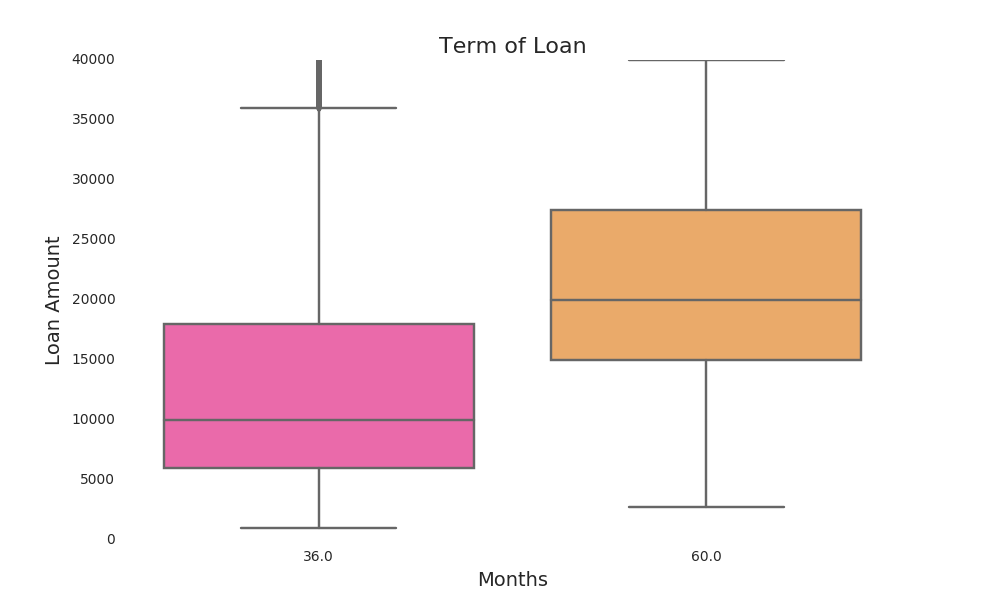

In [19]:
#Graph1
plt.figure(figsize=(10,6))
sns.boxplot("Loan_Term", "Loan_Amount", data=loan_accepted_clean, palette='spring')
plt.title("Term of Loan", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Loan Amount", fontsize=14)
display(plt.draw())

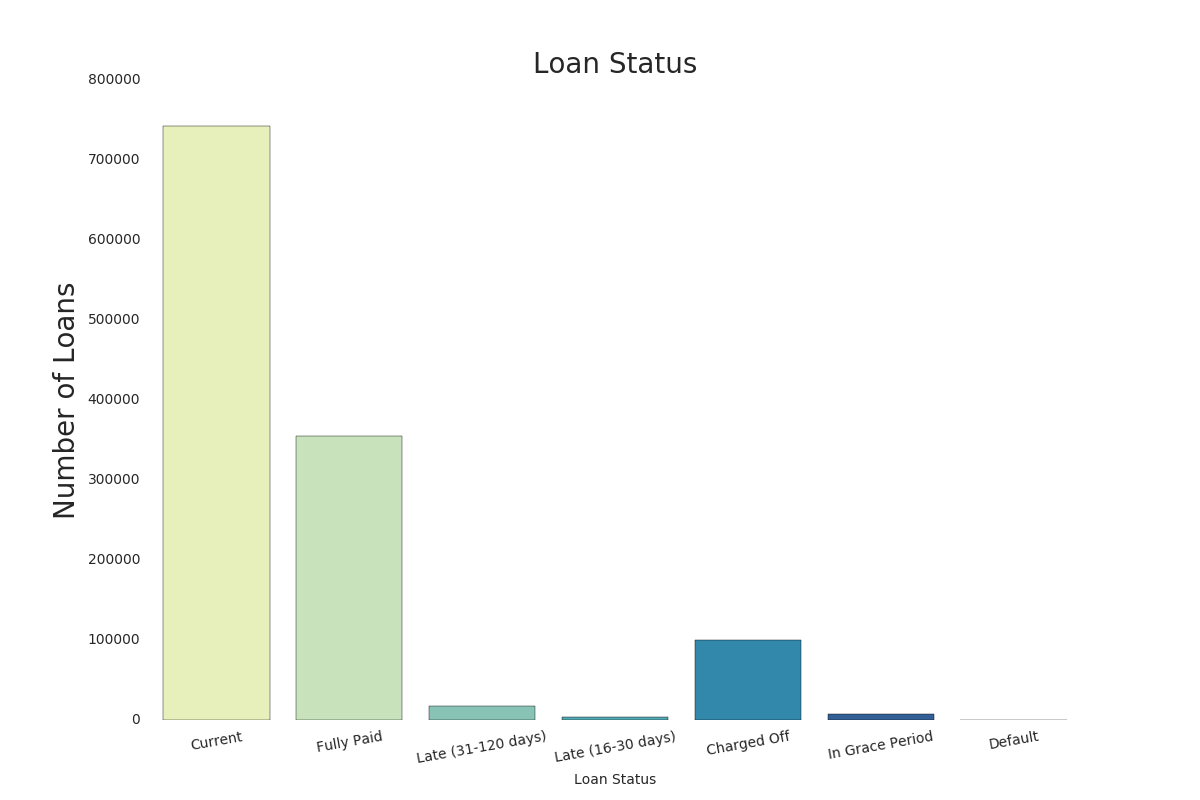

In [20]:
#Graph2
plt.figure(figsize = (12,8))
sns.countplot(x="Loan_Status",data=loan_accepted_clean, palette= "YlGnBu")
plt.xticks(rotation=10)
plt.title("Loan Status", fontsize=20)
plt.xlabel("Loan Status", fontsize=10)
plt.ylabel("Number of Loans", fontsize=20)
display(plt.draw())

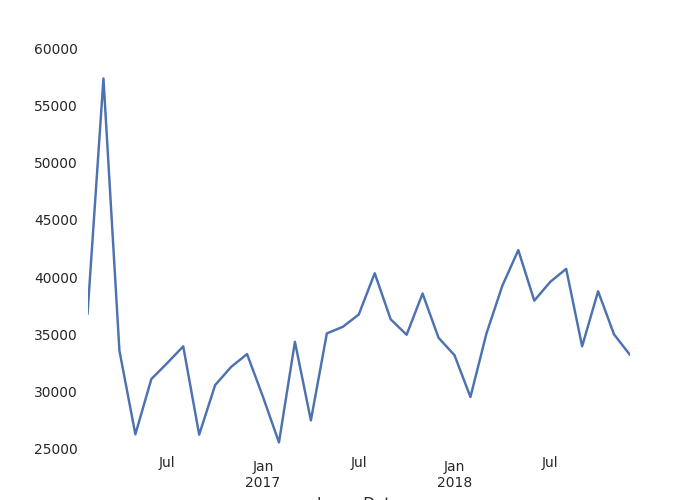

In [21]:
#Graph3
fig, ax = plt.subplots(figsize=(7,5))
loan_accepted_clean.groupby(['Issue_Date']).count()['Loan_Status'].plot(ax=ax)
display(fig)

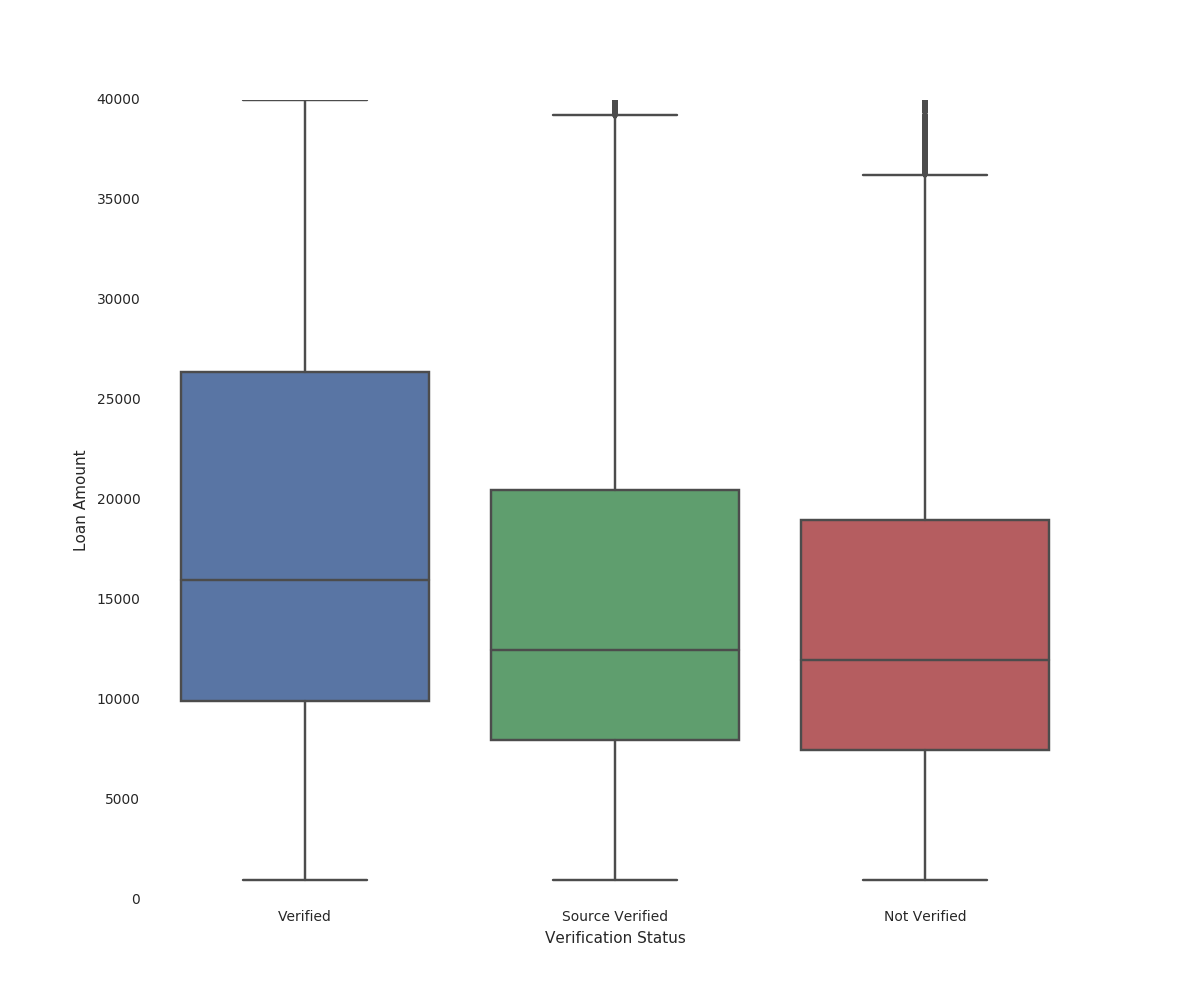

In [22]:
#Graph4
plt.figure(figsize=(12,10))
sns.boxplot(x=loan_accepted_clean.Verification_Status, y=loan_accepted_clean.Loan_Amount)
plt.xlabel("Verification Status")
plt.ylabel("Loan Amount")
display(plt.draw())

In [23]:
#Graph5
h,ax= plt.subplots(figsize=(8, 8))
plt.hist(loans4['Interest_Rate'],bins=10, color='#2CC0DC', ec='black')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Interest Rate Distribution')
display(h)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2137127906878231> in <module> () 
 1 #Graph5 
 2 h , ax = plt . subplots ( figsize = ( 8 , 8 ) ) 
 ----> 3 plt . hist ( loans4 [ 'Interest_Rate' ] , bins = 10 , color = '#2CC0DC' , ec = 'black' ) 
 4 plt . xlabel ( 'Interest Rate' ) 
 5 plt . ylabel ( 'Frequency' ) 

 NameError : name 'loans4' is not defined

In [24]:
#Graph6
f, ax = plt.subplots(figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Fully Paid", "Charged Off"

plt.suptitle('Status of Loans', fontsize=20)
plt.axis('off')

loans4["Loan_Status"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
display(f)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2137127906878232> in <module> () 
 8 plt . axis ( 'off' ) 
 9 
 ---> 10 loans4["Loan_Status"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True, colors=colors, 
 11 labels=labels, fontsize=12, startangle=70)
 12 display ( f ) 

 NameError : name 'loans4' is not defined

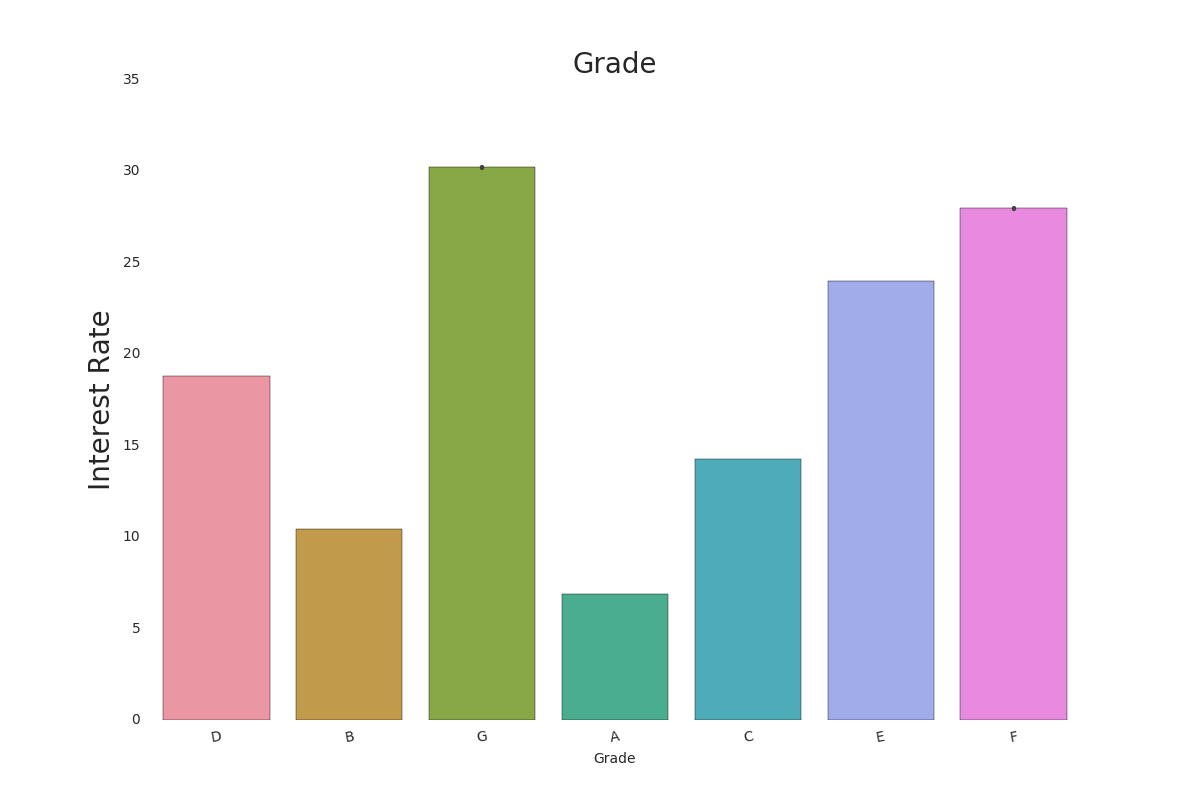

In [25]:
#Graph7
plt.figure(figsize = (12,8))
sns.barplot("Grade", "Interest_Rate", data=loan_accepted_clean)
plt.xticks(rotation=10)
plt.title("Grade", fontsize=20)
plt.xlabel("Grade", fontsize=10)
plt.ylabel("Interest Rate", fontsize=20)
display(plt.draw())

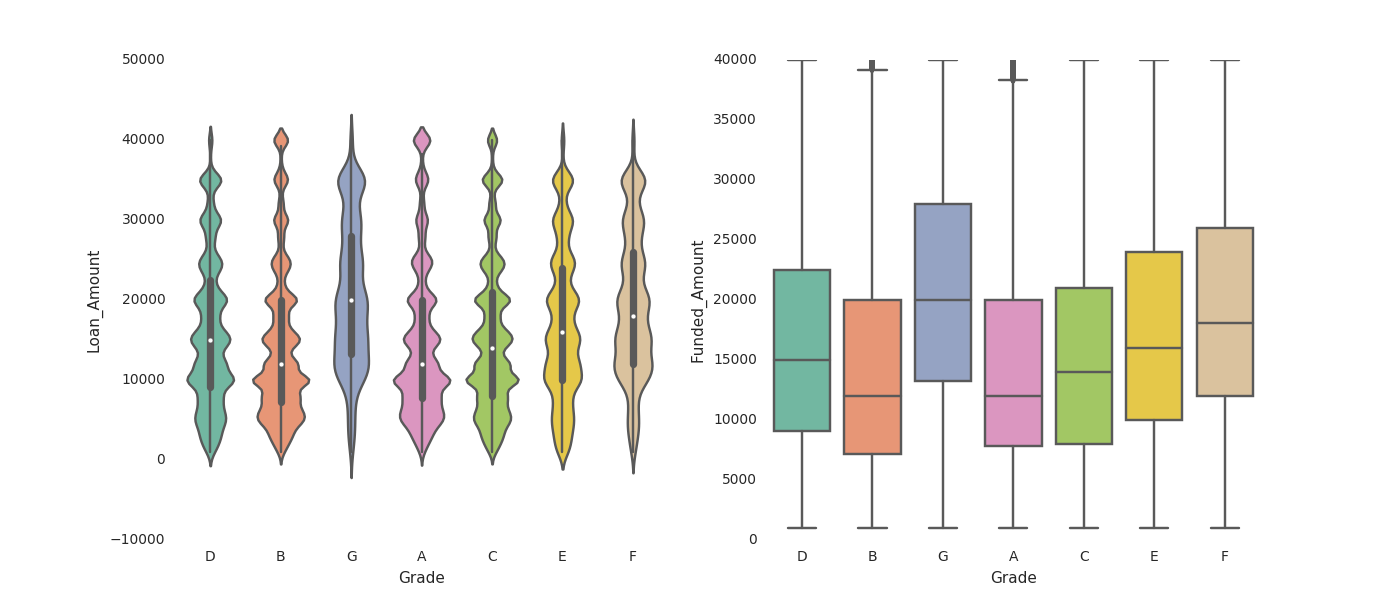

In [26]:
#Graph8
fig, ((ax1), (ax2))= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

sns.violinplot(x="Grade", y="Loan_Amount", data=loan_accepted_clean, palette="Set2", ax=ax1)
sns.boxplot(x="Grade", y="Funded_Amount", data=loan_accepted_clean, palette="Set2", ax=ax2)
display(fig)

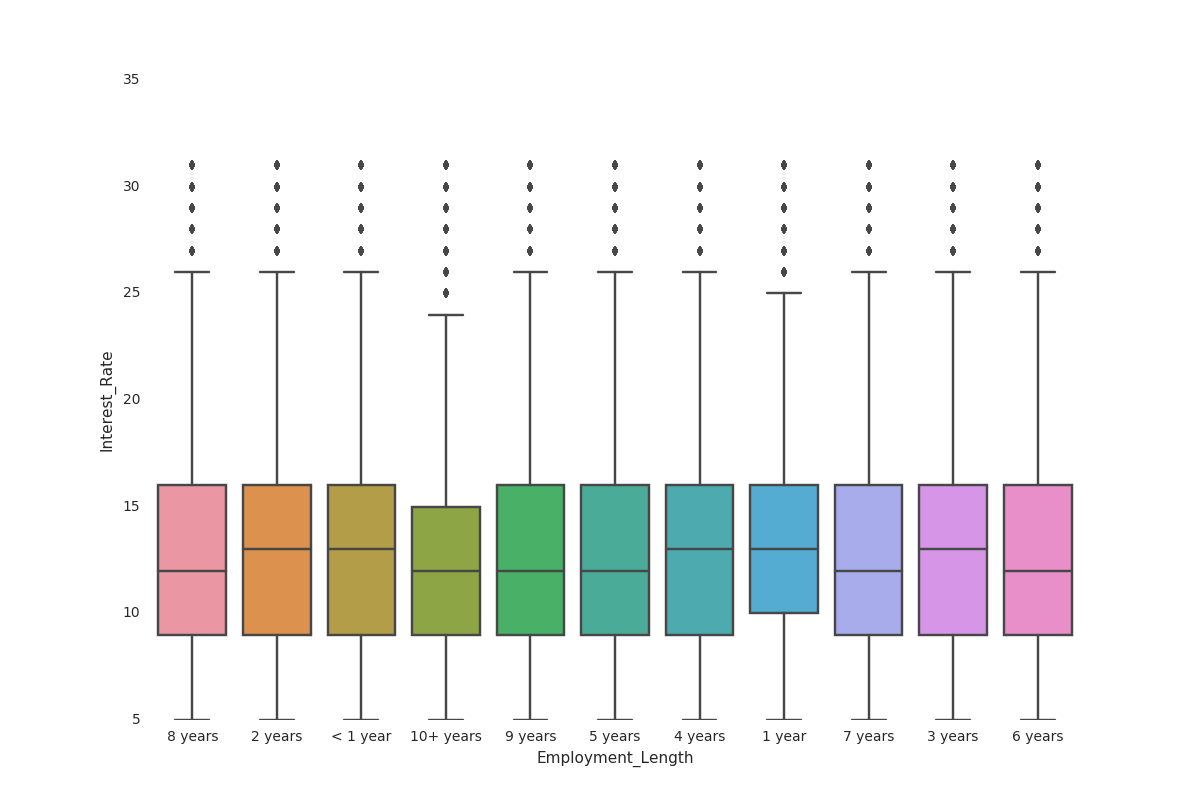

In [27]:
#Graph9
plt.figure(figsize = (12,8))
ax = sns.boxplot(x="Employment_Length" ,y= "Interest_Rate", data=loan_accepted_clean)
display(plt.draw())

In [28]:
#Correlation of features
loan_correlation = loan_accepted_clean.corr()
loan_correlation

,Loan_Amount,Funded_Amount,Funded_Amount_Invested,Loan_Term,Interest_Rate,Installment_Amount,Annual_Income,Debt_To_Income_Ratio,Deliquency_2yrs,Fico_Low,Fico_High,Inquiry_Last_6mnths,Open_Credit_Lines,Revolving_Utlilization
Loan_Amount,1.000000,0.999999,0.999994,0.383788,0.079834,0.945051,0.160703,0.050975,-0.017689,0.108109,0.108107,-0.020626,0.166820,0.092197
Funded_Amount,0.999999,1.000000,0.999995,0.383787,0.079835,0.945052,0.160703,0.050974,-0.017688,0.108110,0.108108,-0.020626,0.166821,0.092195
Funded_Amount_Invested,0.999994,0.999995,1.000000,0.384056,0.079907,0.944946,0.160701,0.050947,-0.017731,0.108210,0.108209,-0.020686,0.166789,0.092176
Loan_Term,0.383788,0.383787,0.384056,1.000000,0.346457,0.132994,0.029670,0.058059,-0.016655,0.025121,0.025120,-0.003172,0.065421,0.050423
Interest_Rate,0.079834,0.079835,0.079907,0.346457,1.000000,0.124159,-0.044087,0.145703,0.060994,-0.409450,-0.409442,0.164634,-0.005037,0.258480
Installment_Amount,0.945051,0.945052,0.944946,0.132994,0.124159,1.000000,0.153496,0.057355,-0.004092,0.044121,0.044120,0.002816,0.158858,0.120678
Annual_Income,0.160703,0.160703,0.160701,0.029670,-0.044087,0.153496,1.000000,-0.075820,0.019453,0.026026,0.026026,0.019152,0.079605,0.028930
Debt_To_Income_Ratio,0.050975,0.050974,0.050947,0.058059,0.145703,0.057355,-0.075820,1.000000,-0.016703,-0.022245,-0.022248,-0.002663,0.212420,0.138691
Deliquency_2yrs,-0.017689,-0.017688,-0.017731,-0.016655,0.060994,-0.004092,0.019453,-0.016703,1.000000,-0.181938,-0.181935,0.025057,0.045299,0.007956
Fico_Low,0.108109,0.108110,0.108210,0.025121,-0.409450,0.044121,0.026026,-0.022245,-0.181938,1.000000,1.000000,-0.088420,0.016385,-0.487600


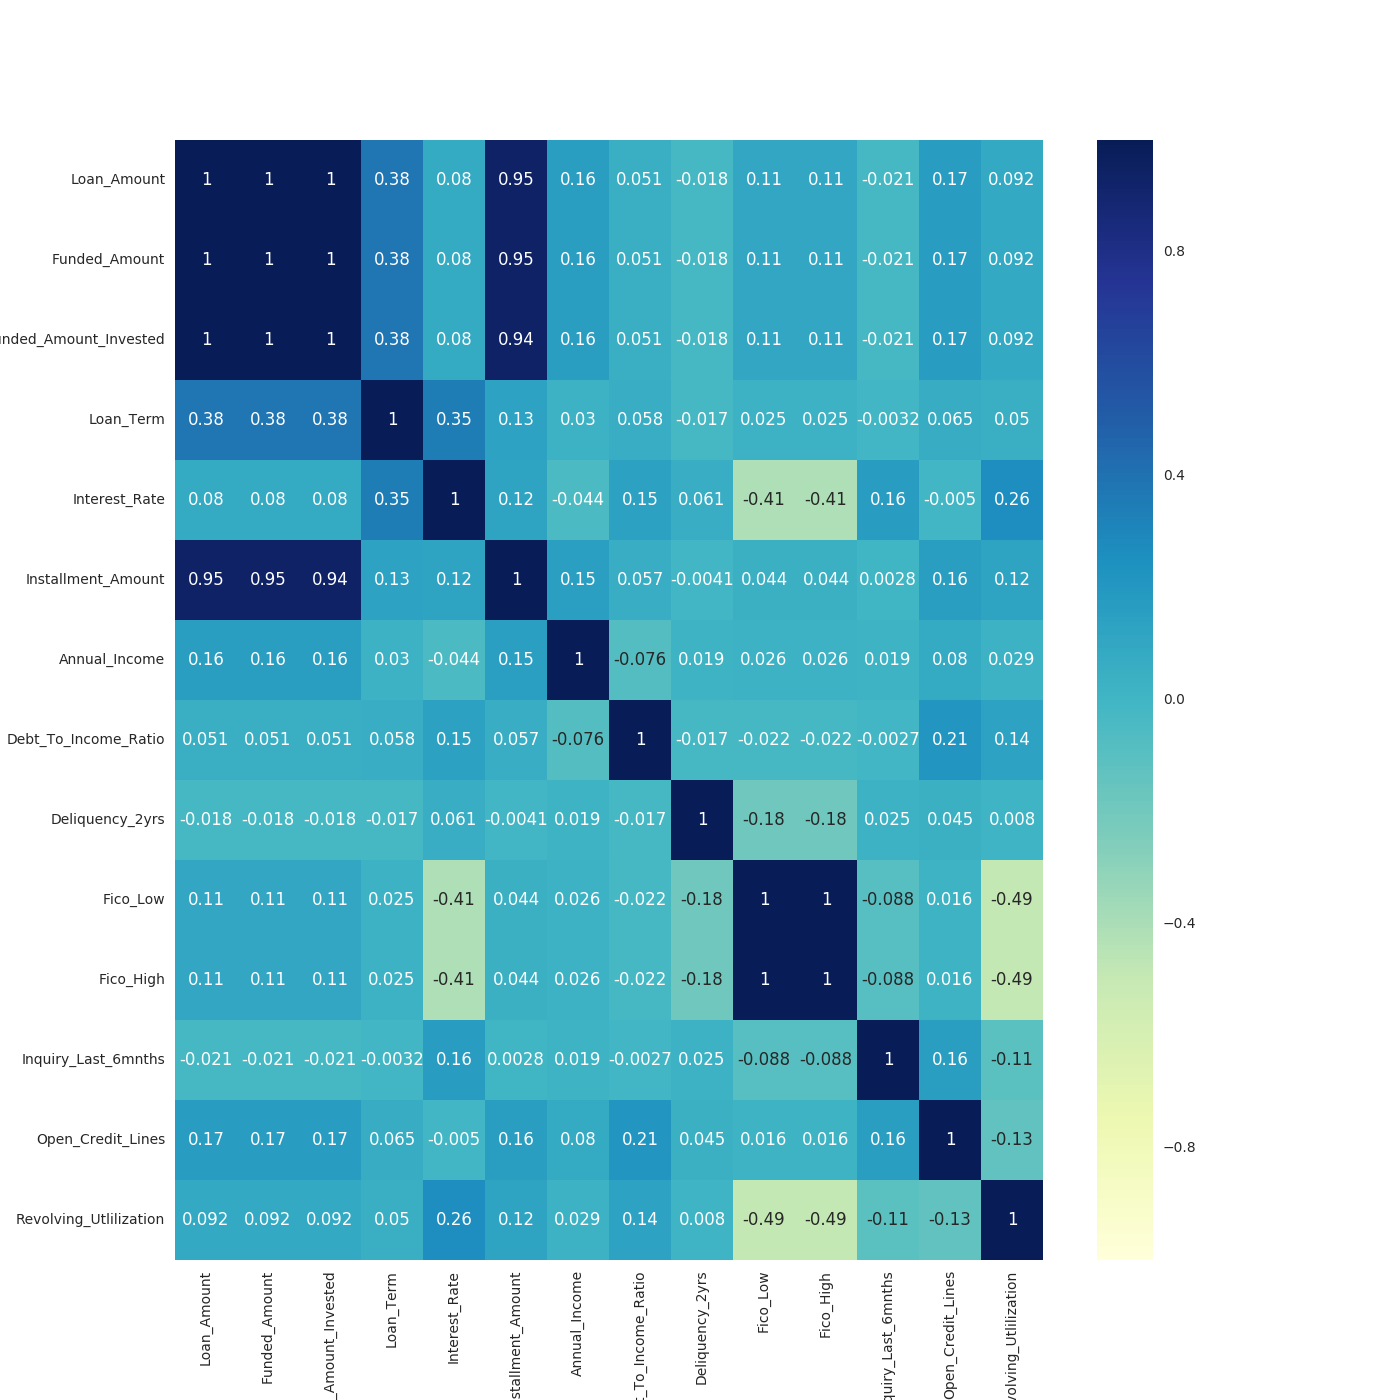

In [29]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,cmap="YlGnBu",annot= True)
display(f)

In [30]:
#Taking a mean of Fico_Low and Fico_High and making a new feature Fico
loan_accepted_clean['Fico'] = loan_accepted_clean[['Fico_Low', 'Fico_High']].mean(axis=1)

In [31]:
#Dropping unused features
loan= loan_accepted_clean
loan=loan.drop(['Employee_Title','Employment_Length','Purpose','State','Earliest_Credit_Line','Issue_Date','Fico_High','Fico_Low'],axis=1)

In [32]:
dummy1 = loan
dummy2 = pd.get_dummies(dummy1['Loan_Status'])
dummy2 = pd.concat([dummy1, dummy2], axis = 1)

dummy3 = dummy2
dummy3 = pd.get_dummies(dummy3['Grade'])
dummy3 = pd.concat([dummy2, dummy3], axis = 1)

dummy4 = dummy3
dummy4 = pd.get_dummies(dummy4['Home_Ownership_Status'])
dummy4 = pd.concat([dummy3, dummy4], axis = 1)

dummy5 = dummy4
dummy5 = pd.get_dummies(dummy5['Verification_Status'])
dummy5 = pd.concat([dummy4, dummy5], axis = 1)

dummy6 = dummy5.drop(['Grade', 'Home_Ownership_Status', 'Verification_Status', 'Loan_Status'], axis=1)

In [33]:
linear_reg=spark.createDataFrame(dummy6)

In [34]:
col_list=["Loan_Amount","Funded_Amount","Funded_Amount_Invested","Loan_Term", "Interest_Rate", "Installment_Amount","Annual_Income","Debt_To_Income_Ratio","Deliquency_2yrs","Inquiry_Last_6mnths","Open_Credit_Lines","Revolving_Utlilization", "Fico", "Charged Off", "Default", "Fully Paid", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)", "A","B","C","D","E","F","G", "ANY","MORTGAGE","NONE","OWN","RENT","Not Verified","Source Verified","Verified"]

for col in col_list:
  linear_reg=linear_reg.withColumn(col, linear_reg[col].cast('Integer'))

In [35]:
#Splitting the dataset 
training_df, validation_df, testing_df = linear_reg.randomSplit([0.6, 0.3, 0.1], seed=100)

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, LinearRegressionSummary
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [37]:
#Linear Model 1
#Features with correlation more than 0.1
va1 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Revolving_Utlilization'], outputCol='features')
sc1 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
lr1 = LinearRegression(featuresCol='f', labelCol='Interest_Rate', maxIter=15)

pipe1 = Pipeline(stages=[va1,sc1,lr1])

pipe_model1 = pipe1.fit(training_df)

In [38]:
rmse1 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse1_df = pipe_model1.transform(validation_df).select(rmse1).show()

+------------------+
 rmse|
+------------------+
3.3233575341103014|
+------------------+

In [39]:
rmse_1_df = pipe_model1.transform(testing_df)

eval = RegressionEvaluator(labelCol="Interest_Rate", predictionCol="prediction")
print('R-squared:', eval.evaluate(rmse_1_df , {eval.metricName: "r2"}))

R-squared: 0.5831575555062676

In [40]:
#Linear Model 2
va2 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Annual_Income','Deliquency_2yrs','Inquiry_Last_6mnths','Open_Credit_Lines',"Charged Off", "Default", "Fully Paid", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",'Revolving_Utlilization'], outputCol='features')
sc2= StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
lr2 = LinearRegression(featuresCol='f', labelCol='Interest_Rate', maxIter=15)

pipe2 = Pipeline(stages=[va2,sc2,lr2])

pipe_model2 = pipe2.fit(training_df)

In [41]:
rmse2 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse2_df = pipe_model2.transform(validation_df).select(rmse2).show()
rmse_2_df = pipe_model2.transform(testing_df)

+-----------------+
 rmse|
+-----------------+
3.263580953505582|
+-----------------+

In [42]:
eval = RegressionEvaluator(labelCol="Interest_Rate", predictionCol="prediction")
print('R-squared:', eval.evaluate(rmse_2_df , {eval.metricName: "r2"}))

R-squared: 0.5987628521721983

In [43]:
#Linear Model 3
va3 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Revolving_Utlilization','A','B','C','D','E','F','G','ANY','MORTGAGE','NONE','OWN','RENT','Not Verified','Source Verified','Verified'], outputCol='features')
sc3= StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
lr3 = LinearRegression(featuresCol='f', labelCol='Interest_Rate', maxIter=15)

pipe3 = Pipeline(stages=[va3,sc3,lr3])

pipe_model3 = pipe3.fit(training_df)

In [44]:
rmse3 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse3_df = pipe_model3.transform(validation_df).select(rmse3).show()
rmse_3_df = pipe_model3.transform(testing_df)

+------------------+
 rmse|
+------------------+
1.2390455272992373|
+------------------+

In [45]:
eval = RegressionEvaluator(labelCol="Interest_Rate", predictionCol="prediction")
print('R-squared:', eval.evaluate(rmse_3_df , {eval.metricName: "r2"}))

R-squared: 0.9421966194106226

In [46]:
#Linear Model 4
va4 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Deliquency_2yrs','Inquiry_Last_6mnths','Revolving_Utlilization','A','B','C','D','E','F','G'], outputCol='features')
sc4= StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
lr4 = LinearRegression(featuresCol='f', labelCol='Interest_Rate', maxIter=15)

pipe4 = Pipeline(stages=[va4,sc4,lr4])

pipe_model4 = pipe4.fit(training_df)

In [47]:
rmse4 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse4_df = pipe_model4.transform(validation_df).select(rmse4).show()
rmse_4_df = pipe_model4.transform(testing_df)

+------------------+
 rmse|
+------------------+
1.2403769959859468|
+------------------+

In [48]:
eval = RegressionEvaluator(labelCol="Interest_Rate", predictionCol="prediction")
print('R-squared:', eval.evaluate(rmse_4_df , {eval.metricName: "r2"}))

R-squared: 0.9420417456653533

In [49]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer

In [50]:
#Decision Tree - 1st Model
#Features with correlation more than 0.1
vaD1 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Revolving_Utlilization'], outputCol='features')
scD1 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
dtr1 = DecisionTreeRegressor(featuresCol='f', labelCol='Interest_Rate', maxDepth = 15, maxBins = 64)

pipeD1 = Pipeline(stages=[vaD1,scD1,dtr1])

pipe_modelD1 = pipeD1.fit(training_df)

In [51]:
rmseD1 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmseD2')
rmse1_dfD1 = pipe_modelD1.transform(validation_df).select(rmseD1).show()

+------------------+
 rmseD2|
+------------------+
2.8744292582934414|
+------------------+

In [52]:
#Decision Tree - 2nd Model
vaD2 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Annual_Income','Deliquency_2yrs','Inquiry_Last_6mnths','Open_Credit_Lines',"Charged Off", "Default", "Fully Paid", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)",'Revolving_Utlilization'], outputCol='features')
scD2= StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
dtr2 = DecisionTreeRegressor(featuresCol='f', labelCol='Interest_Rate', maxDepth = 15, maxBins = 64)

pipeD2 = Pipeline(stages=[vaD2,scD2,dtr2])

pipe_modelD2 = pipeD2.fit(training_df)

In [53]:
rmseD2 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse2_dfD2 = pipe_modelD2.transform(validation_df).select(rmseD2).show()

+-----------------+
 rmse|
+-----------------+
2.882396775544306|
+-----------------+

In [54]:
#Decision Tree- 3rd Model
vaD3 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Revolving_Utlilization','A','B','C','D','E','F','G','ANY','MORTGAGE','NONE','OWN','RENT','Not Verified','Source Verified','Verified'], outputCol='features')
scD3= StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
dtr3 = DecisionTreeRegressor(featuresCol='f', labelCol='Interest_Rate', maxDepth = 15, maxBins = 64)

pipeD3 = Pipeline(stages=[vaD3,scD3,dtr3])

pipe_modelD3 = pipeD3.fit(training_df)

In [55]:
rmseD3 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse3_dfD3 = pipe_modelD3.transform(validation_df).select(rmseD3).show()

+-----------------+
 rmse|
+-----------------+
1.002038706166517|
+-----------------+

In [56]:
#Decision Tree- 4th Model
vaD4 = VectorAssembler(inputCols=['Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Deliquency_2yrs','Inquiry_Last_6mnths','Revolving_Utlilization','A','B','C','D','E','F','G'], outputCol='features')
scD4= StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='f')
dtr4 = DecisionTreeRegressor(featuresCol='f', labelCol='Interest_Rate', maxDepth = 15, maxBins = 64)

pipeD4 = Pipeline(stages=[vaD4,scD4,dtr4])

pipe_modelD4= pipeD4.fit(training_df)

In [57]:
rmseD4 = fn.sqrt(fn.mean((fn.col('Interest_Rate') - fn.col('prediction'))**2)).alias('rmse')
rmse4_dfD4 = pipe_modelD4.transform(validation_df).select(rmseD4).show()

+------------------+
 rmse|
+------------------+
0.9982568450078009|
+------------------+

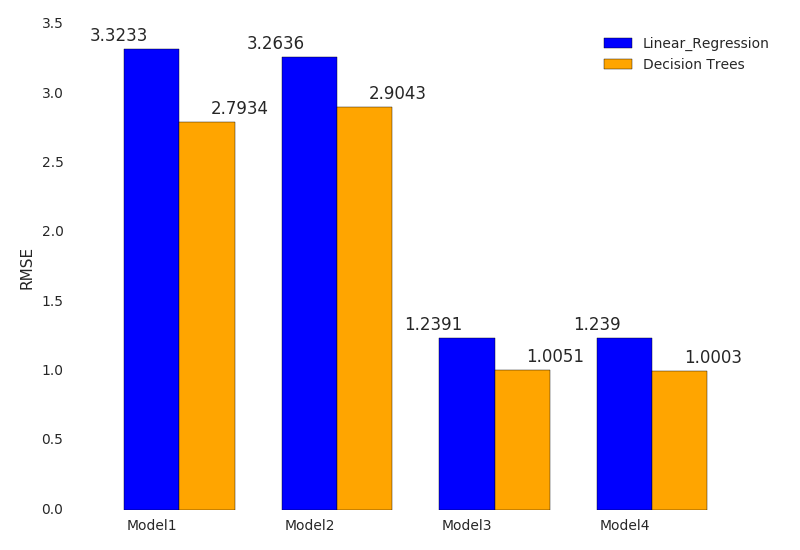

In [58]:
import numpy as np

#The data
linear_regression = np.array([3.3233, 3.2636, 1.2391, 1.2390], dtype=float)
decision_tree = np.array([2.7934, 2.9043, 1.0051, 1.0003], dtype=float)
width = 0.35
fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(len(linear_regression)) 
rects1 = ax.bar(ind - width/2, linear_regression, width,
                label='Linear_Regression', color='Blue')
rects2 = ax.bar(ind + width/2, decision_tree, width,
                label='Decision Trees', color='Orange')

ax.set_ylabel('RMSE')
ax.set_xticks(ind)
ax.set_xticklabels(('Model1', 'Model2', 'Model3', 'Model4', 'Model5'))
ax.legend()
def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

display(fig)

In [59]:
loans= loan
loans=loans[(loans.Loan_Status =='Fully Paid') | (loans.Loan_Status == 'Charged Off')]
loans['Loan_Status'].value_counts(ascending=True)

Out[ 71 ]: Charged Off 99895
Fully Paid 354917
Name: Loan_Status, dtype: int64

In [60]:
dummy_1 = loans
dummy_1['Loan_Status'] = dummy_1['Loan_Status'].map({'Fully Paid':1, 'Charged Off':0})

dummy_2 = dummy_1
dummy_2 = pd.get_dummies(dummy_2['Grade'])
dummy_2 = pd.concat([dummy_1, dummy_2], axis = 1)

dummy_3 = dummy_2
dummy_3 = pd.get_dummies(dummy_3['Home_Ownership_Status'])
dummy_3 = pd.concat([dummy_2, dummy_3], axis = 1)

dummy_4 = dummy_3
dummy_4 = pd.get_dummies(dummy_4['Verification_Status'])
dummy_4 = pd.concat([dummy_3, dummy_4], axis = 1)

dummy_5 = dummy_4.drop(['Grade', 'Home_Ownership_Status', 'Verification_Status'], axis=1)

/local_disk0/tmp/1574384191355-0/PythonShell.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 from __future__ import print_function

In [61]:
logistic_reg=spark.createDataFrame(dummy_5)

In [62]:
col_list=["Loan_Amount","Funded_Amount","Funded_Amount_Invested","Loan_Term", "Interest_Rate", "Installment_Amount","Loan_Status","Annual_Income","Debt_To_Income_Ratio","Deliquency_2yrs","Inquiry_Last_6mnths","Open_Credit_Lines","Revolving_Utlilization","A","B","C","D","E","F","G", "Fico","ANY","MORTGAGE","NONE","OWN","RENT","Not Verified","Source Verified","Verified"]

for col in col_list:
  logistic_reg=logistic_reg.withColumn(col, logistic_reg[col].cast('Integer'))

In [63]:
training1_df, validation1_df, testing1_df = logistic_reg.randomSplit([0.6, 0.3, 0.1], seed=100)

In [64]:
dataset_size=float(training1_df.select("Loan_Status").count())
numPositives=training1_df.select("Loan_Status").where('Loan_Status == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 213641
Percentage of ones are 78.10999842786266

In [65]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.21890001572137338

In [66]:
from pyspark.sql import functions as F
training1_df=training1_df.withColumn("classWeights", F.when(training1_df.Loan_Status == 1,BalancingRatio).otherwise(1-BalancingRatio))
training1_df.select("classWeights").show(5)

+-------------------+
 classWeights|
+-------------------+
0.21890001572137338|
0.21890001572137338|
0.21890001572137338|
0.21890001572137338|
0.21890001572137338|
+-------------------+
only showing top 5 rows

In [67]:
from pyspark.ml.feature import StandardScaler
columns= logistic_reg.columns
assembler = VectorAssembler(inputCols=columns,outputCol="outfeatures")
# scaling the features by MaxAbsScaler
scaler = StandardScaler(inputCol="outfeatures", outputCol="ScaledFeatures")
#creating pipeline with scaled feature


lr_scaled = LogisticRegression().\
    setLabelCol('Loan_Status').\
    setFeaturesCol('ScaledFeatures').\
    setMaxIter(100).\
    setWeightCol('classWeights')
logistic_pipeline1= Pipeline(stages=[assembler,scaler,lr_scaled])
logistic_pipeline_fit1=logistic_pipeline1.fit(training1_df)


In [68]:
evaluator = BinaryClassificationEvaluator(labelCol=lr_scaled.getLabelCol(), rawPredictionCol=lr_scaled.getRawPredictionCol())

In [69]:
AUC_validation = evaluator.evaluate(logistic_pipeline_fit1.transform(validation_df))
print(AUC1)

1.0

In [70]:
AUC_test = evaluator.evaluate(logistic_pipeline_fit1.transform(testing1_df))
print(AUC_test)

1.0

In [71]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr_scaled.regParam, [0.01, 0.2])
             .addGrid(lr_scaled.elasticNetParam, [0.4,0.6])
             .addGrid(lr_scaled.maxIter, [10, 100, 1000])
             .build())

In [72]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
cv= CrossValidator(estimator=logistic_pipeline1, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, parallelism=3)
    
# Run cross validations
cvModel = cv.fit(training1_df)

/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [73]:
 predict_validation=cvModel.transform(validation1_df)
print("The area under ROC for validation set after CV  is {}".format(evaluator.evaluate(predict_validation)))

print(predict_validation)

The area under ROC for validation set after CV is 1.0
DataFrame[Loan_Amount: int, Funded_Amount: int, Funded_Amount_Invested: int, Loan_Term: int, Interest_Rate: int, Installment_Amount: int, Annual_Income: int, Loan_Status: int, Debt_To_Income_Ratio: int, Deliquency_2yrs: int, Inquiry_Last_6mnths: int, Open_Credit_Lines: int, Revolving_Utlilization: int, Fico: int, A: int, B: int, C: int, D: int, E: int, F: int, G: int, ANY: int, MORTGAGE: int, NONE: int, OWN: int, RENT: int, Not Verified: int, Source Verified: int, Verified: int, outfeatures: vector, ScaledFeatures: vector, rawPrediction: vector, probability: vector, prediction: double]

In [74]:
cvModel.bestModel.stages[-1].coefficients

Out[ 90 ]: SparseVector(29, {4: -0.093, 7: 0.9729, 13: -0.0476})

In [75]:
predictions_logistic_val = cvModel.bestModel.transform(validation1_df)
print("The area under ROC for validation set after CV  is {}".format(evaluator.evaluate(predictions_logistic_val)))


The area under ROC for validation set after CV is 1.0

In [76]:
predictions_logistic = cvModel.bestModel.transform(testing1_df)
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predictions_logistic)))



The area under ROC for test set after CV is 1.0

In [77]:
predictions_logistic= predictions_logistic.withColumn('label',fn.col('Loan_Status'))
predictions_logistic.select("label","rawPrediction","prediction","probability").show(5)

+-----+--------------------+----------+--------------------+
label| rawPrediction|prediction| probability|
+-----+--------------------+----------+--------------------+
 1|[-1.0720249072922...| 1.0|[0.25501819355919...|
 1|[-1.1719438809052...| 1.0|[0.23650379841201...|
 1|[-1.1047187681659...| 1.0|[0.24885678390302...|
 1|[-1.1088643508645...| 1.0|[0.24808266927997...|
 1|[-1.0731790031456...| 1.0|[0.25479899590987...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

In [78]:
tp = predictions_logistic[(predictions_logistic.label == 1) & (predictions_logistic.prediction == 1)].count()
tn = predictions_logistic[(predictions_logistic.label == 0) & (predictions_logistic.prediction == 0)].count()
fp = predictions_logistic[(predictions_logistic.label == 0) & (predictions_logistic.prediction == 1)].count()
fn = predictions_logistic[(predictions_logistic.label == 1) & (predictions_logistic.prediction == 0)].count()

In [79]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 35148
True Negatives: 10132
False Positives: 0
False Negatives: 0

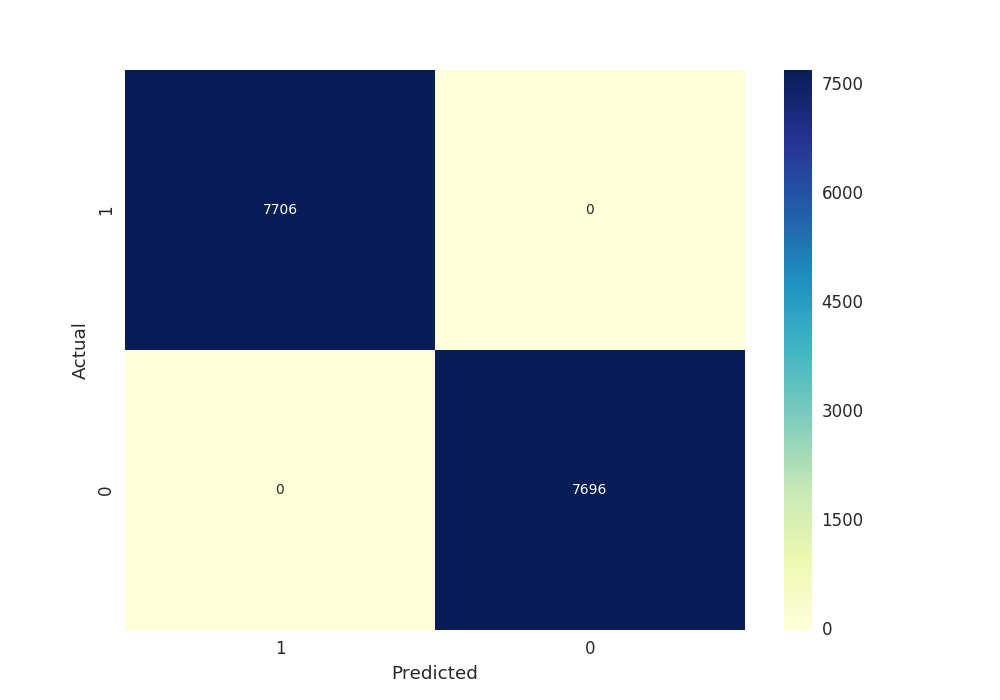

In [80]:
array = [[7696,0],
     [0,7706]]        
df_cm = pd.DataFrame(array, range(2),
                  range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 10},cmap='YlGnBu',fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
display()

In [81]:
random_forest=logistic_reg

In [82]:

stratified_dummy_rf = random_forest.sampleBy('Loan_Status', fractions={0: 0.78, 1: 0.22}).cache()

stratified_dummy_rf.groupby('Loan_Status').count().show()


+-----------+-----+
Loan_Status|count|
+-----------+-----+
 1|78208|
 0|77790|
+-----------+-----+

In [83]:
training2_df, validation2_df, testing2_df = stratified_dummy_rf.randomSplit([0.6, 0.3, 0.1])

In [84]:
cols=stratified_dummy_rf.columns
cols

Out[ 100 ]: ['Loan_Amount',
 'Funded_Amount',
 'Funded_Amount_Invested',
 'Loan_Term',
 'Interest_Rate',
 'Installment_Amount',
 'Annual_Income',
 'Loan_Status',
 'Debt_To_Income_Ratio',
 'Deliquency_2yrs',
 'Inquiry_Last_6mnths',
 'Open_Credit_Lines',
 'Revolving_Utlilization',
 'Fico',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'ANY',
 'MORTGAGE',
 'NONE',
 'OWN',
 'RENT',
 'Not Verified',
 'Source Verified',
 'Verified']

In [85]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=cols,outputCol="feat")
#scaler= StandardScaler(withMean=True, withStd=False, inputCol='output_rf', outputCol='f')
# scaling the features by MaxAbsScale


In [86]:
pipe_rf1 = Pipeline(stages = [assembler,classification.RandomForestClassifier(featuresCol = "feat",\
                            maxDepth = 1, numTrees=60,labelCol="Loan_Status")]).fit(training2_df)
pipe_rf2 = Pipeline(stages = [assembler,classification.RandomForestClassifier(featuresCol = "feat",\
                            maxDepth = 3, numTrees=40,labelCol="Loan_Status")]).fit(training2_df)
pipe_rf3 = Pipeline(stages = [assembler,classification.RandomForestClassifier(featuresCol = "feat",\
                            maxDepth = 6, numTrees=20,labelCol="Loan_Status")]).fit(training2_df)

In [87]:
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='Loan_Status', metricName='areaUnderROC')

In [88]:
AUC1 = evaluator.evaluate(pipe_rf1.transform(validation2_df))
AUC2 = evaluator.evaluate(pipe_rf2.transform(validation2_df))
AUC3 = evaluator.evaluate(pipe_rf3.transform(validation2_df))
print(AUC1)
print(AUC2)
print(AUC3)

1.0
1.0
1.0

In [89]:
AUC_test1 = evaluator.evaluate(pipe_rf1.transform(testing2_df))
AUC_test2 = evaluator.evaluate(pipe_rf2.transform(testing2_df))
AUC_test3 = evaluator.evaluate(pipe_rf3.transform(testing2_df))
print(AUC_test1)
print(AUC_test2)
print(AUC_test3)

1.0
1.0
1.0

In [90]:
rf3 = classification.RandomForestClassifier(maxDepth = 6, numTrees = 20, featuresCol = 'feat', labelCol = 'Loan_Status')
predictions_rf =Pipeline(stages=[assembler, rf3]).fit(stratified_dummy_rf) 

In [91]:
predictions_rf.stages[-1]

Out[ 107 ]: RandomForestClassificationModel (uid=RandomForestClassifier_238439dcb143) with 20 trees

In [92]:
rf_model=predictions_rf.stages[-1]
stratified_df_pandas=stratified_dummy_rf.toPandas()
stratified_df_pandas=stratified_df_pandas.drop(['Loan_Status'], axis=1)
features_list=list(stratified_df_pandas.columns)
feature_importance = pd.DataFrame(list(zip(features_list, rf_model.featureImportances.toArray())),
             columns = ['feature', 'importance']).sort_values('importance', ascending = False)

In [93]:
feature_importance

,feature,importance
7,Debt_To_Income_Ratio,0.902488
4,Interest_Rate,0.040323
13,A,0.009074
3,Loan_Term,0.007955
14,B,0.007769
18,F,0.005987
15,C,0.005759
17,E,0.004052
16,D,0.003662
5,Installment_Amount,0.002793


In [94]:
from pyspark.sql import Row
raw_data = [Row(Loan_Term = 60, Fico = 650, Debt_To_Income_Ratio = 23, Installment_Amount = 550, Loan_Amount =30000, Funded_Amount = 30000, Funded_Amount_Invested = 30000, Deliquency_2yrs = 1, Inquiry_Last_6mnths = 2 ,Revolving_Utlilization = 10, A = 0, B = 0, C = 1, D = 0, E = 0, F = 0, G = 0)]
#raw_data
data_df = spark.createDataFrame(raw_data)
#data_df.show()
predictions_dt = pipe_modelD4.transform(data_df)
predictions_dt.select('prediction').show()

+-----------------+
 prediction|
+-----------------+
12.81230448383733|
+-----------------+

In [95]:
predictions_lr = pipe_model4.transform(data_df)
predictions_lr.select('prediction').show()

+------------------+
 prediction|
+------------------+
13.376527132070882|
+------------------+

In [96]:
predictions_logr = cvModel.transform(data_df)
predictions_logr.select('prediction').show()

--------------------------------------------------------------------------- 
 IllegalArgumentException Traceback (most recent call last)
 <command-2137127906878264> in <module> () 
 ----> 1 predictions_logr = cvModel . transform ( data_df ) 
 2 predictions_logr . select ( 'prediction' ) . show ( ) 

 /databricks/spark/python/pyspark/ml/base.py in transform (self, dataset, params) 
 171 return self . copy ( params ) . _transform ( dataset ) 
 172 else : 
 --> 173 return self . _transform ( dataset ) 
 174 else : 
 175 raise ValueError ( "Params must be a param map but got %s." % type ( params ) ) 

 /databricks/spark/python/pyspark/ml/tuning.py in _transform (self, dataset) 
 420 
 421 def _transform ( self , dataset ) : 
 --> 422 return self . bestModel . transform ( dataset ) 
 423 
 424 @ since ( "1.4.0" ) 

 /databricks/spark/python/pyspark/ml/base.py in transform (self, dataset, params) 
 171 return self . copy ( params ) . _transform ( dataset ) 
 172 else : 
 --> 173 return self . _transform ( dataset ) 
 174 else : 
 175 raise ValueError ( "Params must be a param map but got %s." % type ( params ) ) 

 /databricks/spark/python/pyspark/ml/pipeline.py in _transform (self, dataset) 
 260 def _transform ( self , dataset ) : 
 261 for t in self . stages : 
 --> 262 dataset = t . transform ( dataset ) 
 263 return dataset 
 264 

 /databricks/spark/python/pyspark/ml/base.py in transform (self, dataset, params) 
 171 return self . copy ( params ) . _transform ( dataset ) 
 172 else : 
 --> 173 return self . _transform ( dataset ) 
 174 else : 
 175 raise ValueError ( "Params must be a param map but got %s." % type ( params ) ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _transform (self, dataset) 
 310 def _transform ( self , dataset ) : 
 311 self . _transfer_params_to_java ( ) 
 --> 312 return DataFrame ( self . _java_obj . transform ( dataset . _jdf ) , dataset . sql_ctx ) 
 313 
 314 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 77 raise QueryExecutionException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 78 if s . startswith ( 'java.lang.IllegalArgumentException: ' ) : 
 ---> 79 raise IllegalArgumentException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 80 raise 
 81 return deco 

 IllegalArgumentException : 'Field "Interest_Rate" does not exist.\nAvailable fields: A, B, C, D, Debt_To_Income_Ratio, Deliquency_2yrs, E, F, Fico, Funded_Amount, Funded_Amount_Invested, G, Inquiry_Last_6mnths, Installment_Amount, Loan_Amount, Loan_Term, Revolving_Utlilization'

In [97]:
predictions_rf = pipe_model4.transform(data_df)
predictions_rf.select('prediction').show()

In [98]:
from pyspark.sql import Row
raw_data = [Row(Open_Credit_Lines = 1,Annual_Income = 105000, Interest_Rate = 12,Loan_Term = 60, Fico = 650, Debt_To_Income_Ratio = 23, Installment_Amount = 550, Loan_Amount =30000, Funded_Amount = 30000, Funded_Amount_Invested = 30000, Deliquency_2yrs = 1, Inquiry_Last_6mnths = 2 ,Revolving_Utlilization = 10, A = 0, B = 0, C = 1, D = 0, E = 0, F = 0, G = 0,ANY =1,
               MORTGAGE = 0,NONE = 0,OWN = 0,RENT = 0,NotVerified = 1,SourceVerified = 0,Verified = 0)]
data_df = spark.createDataFrame(raw_data)
#"Loan_Amount","Funded_Amount","Funded_Amount_Invested","Loan_Term", "Interest_Rate", "Installment_Amount","Loan_Status","Annual_Income","Debt_To_Income_Ratio","Deliquency_2yrs","Inquiry_Last_6mnths","Open_Credit_Lines","Revolving_Utlilization","A","B","C","D","E","F","G", "Fico","ANY","MORTGAGE","NONE","OWN","RENT","Not Verified","Source Verified","Verified"

In [99]:
predictions_logr = cvModel.bestModel.transform(data_df)
predictions_logr.select('prediction').show()

--------------------------------------------------------------------------- 
 IllegalArgumentException Traceback (most recent call last)
 <command-2137127906878270> in <module> () 
 ----> 1 predictions_logr = cvModel . bestModel . transform ( data_df ) 
 2 predictions_logr . select ( 'prediction' ) . show ( ) 

 /databricks/spark/python/pyspark/ml/base.py in transform (self, dataset, params) 
 171 return self . copy ( params ) . _transform ( dataset ) 
 172 else : 
 --> 173 return self . _transform ( dataset ) 
 174 else : 
 175 raise ValueError ( "Params must be a param map but got %s." % type ( params ) ) 

 /databricks/spark/python/pyspark/ml/pipeline.py in _transform (self, dataset) 
 260 def _transform ( self , dataset ) : 
 261 for t in self . stages : 
 --> 262 dataset = t . transform ( dataset ) 
 263 return dataset 
 264 

 /databricks/spark/python/pyspark/ml/base.py in transform (self, dataset, params) 
 171 return self . copy ( params ) . _transform ( dataset ) 
 172 else : 
 --> 173 return self . _transform ( dataset ) 
 174 else : 
 175 raise ValueError ( "Params must be a param map but got %s." % type ( params ) ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _transform (self, dataset) 
 310 def _transform ( self , dataset ) : 
 311 self . _transfer_params_to_java ( ) 
 --> 312 return DataFrame ( self . _java_obj . transform ( dataset . _jdf ) , dataset . sql_ctx ) 
 313 
 314 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 77 raise QueryExecutionException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 78 if s . startswith ( 'java.lang.IllegalArgumentException: ' ) : 
 ---> 79 raise IllegalArgumentException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 80 raise 
 81 return deco 

 IllegalArgumentException : 'Field "Loan_Status" does not exist.\nAvailable fields: A, ANY, Annual_Income, B, C, D, Debt_To_Income_Ratio, Deliquency_2yrs, E, F, Fico, Funded_Amount, Funded_Amount_Invested, G, Inquiry_Last_6mnths, Installment_Amount, Interest_Rate, Loan_Amount, Loan_Term, MORTGAGE, NONE, NotVerified, OWN, Open_Credit_Lines, RENT, Revolving_Utlilization, SourceVerified, Verified'

In [100]:
raw = [(1,1,105000,12,60,642,23.5,730,30000,30000,30000,1,2,50,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0)]
df_new = pd.DataFrame(raw, columns =['Loan_Status','Open_Credit_Lines','Annual_Income','Interest_Rate','Loan_Term','Fico','Debt_To_Income_Ratio','Installment_Amount','Loan_Amount','Funded_Amount','Funded_Amount_Invested','Deliquency_2yrs','Inquiry_Last_6mnths','Revolving_Utlilization','A','B','C','D','E','F','G','ANY','MORTGAGE','NONE','OWN','RENT','Not Verified','Source Verified','Verified'])

In [101]:
df_new

,Loan_Status,Open_Credit_Lines,Annual_Income,Interest_Rate,Loan_Term,Fico,Debt_To_Income_Ratio,Installment_Amount,Loan_Amount,Funded_Amount,...,F,G,ANY,MORTGAGE,NONE,OWN,RENT,Not Verified,Source Verified,Verified
0,1,1,105000,12,60,642,23.5,730,30000,30000,...,0,0,1,0,0,0,0,1,0,0


In [102]:
data_log_df = spark.createDataFrame(df_new)

In [103]:
predictions_logr = cvModel.bestModel.transform(data_log_df)
predictions_logr.select('Loan_Status',"rawPrediction","prediction","probability").show()

+-----------+--------------------+----------+--------------------+
Loan_Status| rawPrediction|prediction| probability|
+-----------+--------------------+----------+--------------------+
 1|[-1.2223741684265...| 1.0|[0.22751891092545...|
+-----------+--------------------+----------+--------------------+

In [104]:
predictions_logr = pipe_rf3.transform(data_log_df)
predictions_logr.select('Loan_Status',"rawPrediction","prediction","probability").show()

+-----------+--------------------+----------+--------------------+
Loan_Status| rawPrediction|prediction| probability|
+-----------+--------------------+----------+--------------------+
 1|[2.85698382175296...| 1.0|[0.14284919108764...|
+-----------+--------------------+----------+--------------------+